## Taylor Series examples

Created by: Dimitris Giovanis, 23/3/2019


The first-order reliability methods (FORM), as stated by its name, utilizes a first-order Taylor series expansions for the performance function in a standard normal probability space to derive probability of failure estimates. Consider a model in standard normal space  with performance function $g(\textbf{U})$. The FORM approximates
the performance function by:

$g(\textbf{U})  \approx L(\textbf{U}) = g(\textbf{u}^\star) + \nabla g(\textbf{u}^\star)(\textbf{U}-\textbf{u}^\star)^T$


where $\textbf{u}^\star$ is the point around which the series is expanded and its typically called the design point (needs to be found) and it corresponds to the point on the line  $g(\textbf{U})=0$ with the highest probability. $\nabla g(\textbf{u}^\star)$ is the gradient of $g(\textbf{U})$ evaluated at $\textbf{u}^\star$.

The benchmark problem is a simple structural reliability problem
defined in a two-dimensional parameter space consisting of a resistance $R$ and a stress $S$. The failure happens
when the stress is higher than the resistance, leading to the following limit-state function:

$ \textbf{X}=\{R, S\}$

$g(\textbf{X}) = R - S$

The two random variables are independent  and  distributed
according to:

$R \sim N(200, 20)$

$S \sim N(150, 10)$

In [1]:
import numpy as np
from UQpy.Reliability import TaylorSeries
import matplotlib.pyplot as plt
from UQpy.RunModel import RunModel

In [2]:
Q = TaylorSeries(method='FORM', dimension=2, dist_name=['normal', 'normal'], dist_params=[[200, 20], [150, 10]],
                 algorithm='HL', model_script='pfn.py',model_object_name="example1")

Running FORM...
UQpy: Computing Nataf correlation distortion...
UQpy: Done.
UQpy: Computing Nataf correlation distortion...
UQpy: Done.
UQpy: Computing Nataf correlation distortion...
UQpy: Done.


In [3]:
# print results
print('Design point in standard normal space: %s' % Q.DesignPoint_U)
print('Design point in original space: %s' % Q.DesignPoint_X)
print('Hasofer-Lind reliability index: %s' % Q.HL_beta)
print('FORM probability of failure: %s' % Q.Prob_FORM)

Design point in standard normal space: [-2.  1.]
Design point in original space: [ 160.  160.]
Hasofer-Lind reliability index: 2.2360679775
FORM probability of failure: 0.0126736593387


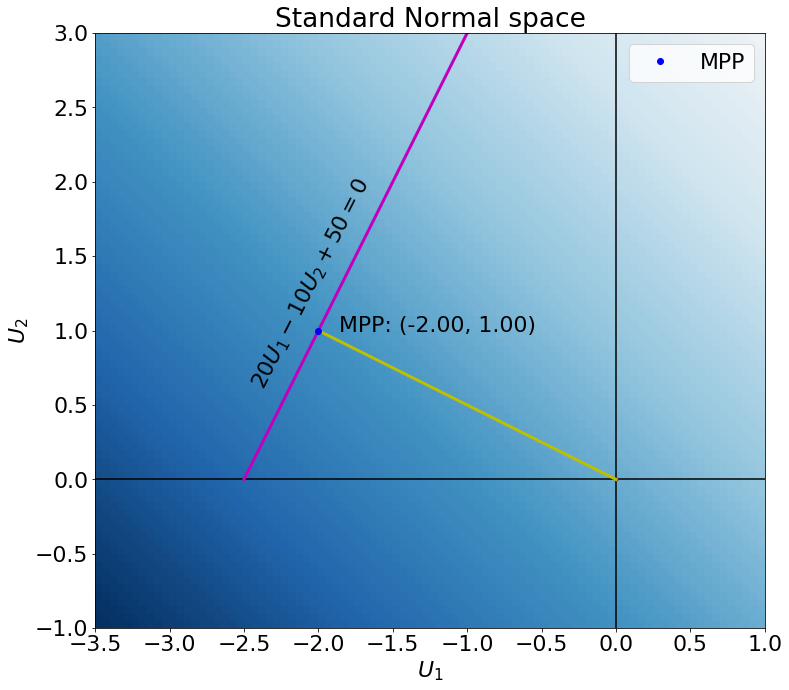

In [89]:
# Plot
dx, dy = 0.05, 0.05
y, x = np.mgrid[slice(-3.5, 1 + dy, dy),
                slice(-1,5 + dx, dx)]
p= np.zeros_like(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        pq = np.array([y[i, j], x[i, j]]).reshape(1, -1)
        p[i, j] = RunModel(samples=pq.reshape(1, -1), model_script='pfn.py', model_object_name="example2").qoi_list[0]
z_min, z_max = -np.abs(p).max(), np.abs(p).max()
# figure
plt.figure()
#
#Exact limit-state function: g(U) = 20U1−10U2 +50
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams.update({'font.size': 22})
plt.pcolor(y,x,p, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.contour(y,x,p,[0]) 
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.plot(0,0,'r.')                                                     
plt.plot([0, Q.DesignPoint_U[0]],[0, Q.DesignPoint_U[1]], 'y', Linewidth=3)   
plt.plot([0, -2.5],[5, 0], 'm', Linewidth=3)
plt.plot(Q.DesignPoint_U[0],Q.DesignPoint_U[1],'bo',label='MPP') 
plt.xlabel(r'$U_1$')
plt.ylabel(r'$U_2$')
plt.text(-1.2, 1.1, 'MPP: ({:1.2f}, {:1.2f})'.format(Q.DesignPoint_U[0], Q.DesignPoint_U[1]),
         rotation=0,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')

plt.text(-2.05, 2.05, '$20U_1 - 10U_2 + 50=0$',
         rotation=63,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')

plt.ylim([-1, 3])
plt.title('Standard Normal space')    
plt.legend() 
plt.axes().set_aspect('equal', 'box')
plt.show()

## Example #2

In the second example we have the limit state to be a linear function of two ($d$=2) independent Gaussian random variables

$g(\textbf{U}) = -\frac{1}{\sqrt{d}}\sum_{i=1}^{d} u_i + \beta$


The probability of failure in this case is $P(F) ≈ 10^{−3}$ for $\beta$ = 3.0902

In [5]:
Z0 = TaylorSeries(method='FORM', dimension=2, dist_name=['normal', 'normal'], dist_params=[[0, 1], [0, 1]],
                 algorithm='HL', model_script='pfn.py',model_object_name="example2")

Running FORM...
UQpy: Computing Nataf correlation distortion...
UQpy: Done.
UQpy: Computing Nataf correlation distortion...
UQpy: Done.
UQpy: Computing Nataf correlation distortion...
UQpy: Done.


In [6]:
# print results
print('Design point in standard normal space: %s' % Z0.DesignPoint_U)
print('Design point in original space: %s' % Z0.DesignPoint_X)
print('Hasofer-Lind reliability index: %s' % Z0.HL_beta)
print('FORM probability of failure: %s' % Z0.Prob_FORM)
print('FORM model evaluations: %s' % Z0.iterations)

Design point in standard normal space: [ 2.18510138  2.18510138]
Design point in original space: [ 2.18510138  2.18510138]
Hasofer-Lind reliability index: 3.0902
FORM probability of failure: 0.00100010878321
FORM model evaluations: 6


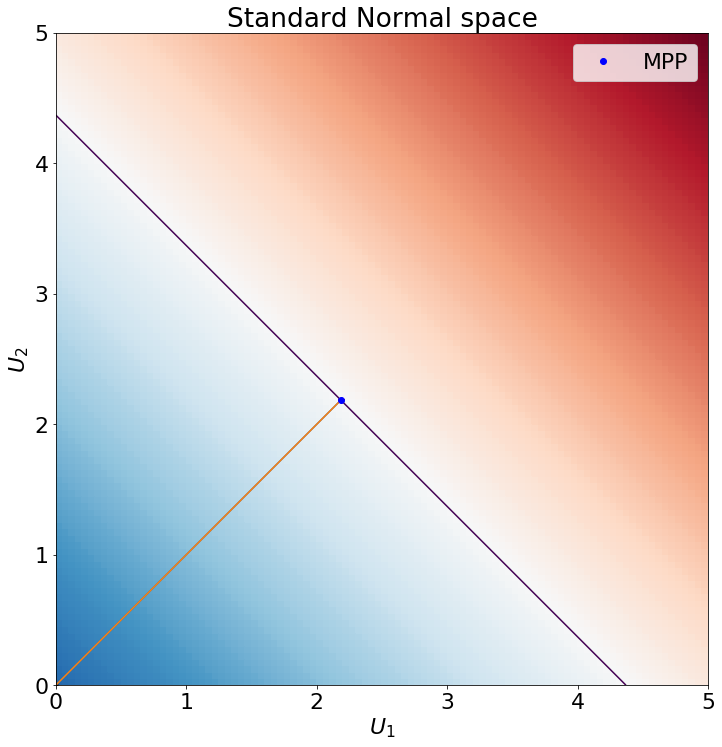

In [38]:
# Plot
dx, dy = 0.05, 0.05
y, x = np.mgrid[slice(0, 5 + dy, dy),
                slice(0, 5 + dx, dx)]
z = np.zeros_like(y)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        pq = np.array([y[i, j], x[i, j]]).reshape(1, -1)
        z[i, j] = RunModel(samples=pq.reshape(1, -1), model_script='pfn.py', model_object_name="example2").qoi_list[0]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
# figure
plt.figure()
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams.update({'font.size': 22})
plt.pcolor(y,x,z, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.contour(y,x,z,[0]) 
plt.plot(0,0,'k.')                                                          # origin in standard    
plt.plot([0, Z0.DesignPoint_U[0]],[0, Z0.DesignPoint_U[1]])                 # reliability index beta
plt.plot(Z0.DesignPoint_U[0],Z0.DesignPoint_U[1],'r*')                      # design point in standard
plt.plot([0, Z0.DesignPoint_U[0]],[0, Z0.DesignPoint_U[1]])                 # reliability index beta
plt.plot(Z0.DesignPoint_U[0],Z0.DesignPoint_U[1],'bo',label='MPP')          # design point in standard    
plt.title('Standard Normal space')  
plt.xlabel(r'$U_1$')
plt.ylabel(r'$U_2$')
plt.legend() 
plt.axes().set_aspect('equal', 'box')
plt.show()